# Analyzing the National Water Model with Xarray, Dask, and Coiled

_This example was adapted from [this notebook](https://github.com/dcherian/dask-demo/blob/main/nwm-aws.ipynb) by Deepak Cherian, Kevin Sampson, and Matthew Rocklin._

You can {download}`download this jupyter notebook <xarray.ipynb>` to follow along.

<iframe class="plausible-event-name=youtube-coiled-xarray" width="560" height="315" src="https://www.youtube.com/embed/blxvfGt9av8?si=-F_kY5K3VK4UvuPc" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" allowfullscreen></iframe>

## The National Water Model Dataset

In this example, we'll perform a county-wise aggregation of output from the National Water Model (NWM) available on the [AWS Open Data Registry](https://registry.opendata.aws/nwm-archive/). You can read more on the NWM from the [Office of Water Prediction](https://water.noaa.gov/about/nwm).

## Problem description

Datasets with high spatio-temporal resolution can get large quickly, vastly exceeding the resources you may have on your laptop. Dask integrates with Xarray to support parallel computing and you can use Coiled to scale to the cloud.

We'll calculate the mean depth to soil saturation for each US county:

- Years: 2020
- Temporal resolution: 3-hourly land surface output
- Spatial resolution: 250 m grid
- 6 TB

This example relies on a few tools:
- `dask` + `coiled` process the dataset in parallel in the cloud
- `xarray` + `flox` to work with the multi-dimensional Zarr datset and aggregate to county-level means from the 250m grid.

## Before you start

You'll first need to install the necessary packages. For the purposes of this example, we'll do this in a new virtual environment, but you could also install them in whatever environment you're already using for your project.

```
conda create -n coiled-xarray -c conda-forge python=3.10 coiled dask xarray flox rioxarray zarr s3fs geopandas geoviews matplotlib
conda activate coiled-xarray
```
  
You also could use `pip` for everything, or any other package manager you prefer; `conda` isn't required.

When you later create a Coiled cluster, your local `coiled-xarray` environment will be automatically replicated on your cluster.

## Start a Coiled cluster

To demonstrate calculation on a cloud-available dataset, we will use Coiled to set up a dask cluster in AWS `us-east-1`.

In [ ]:
import coiled

cluster = coiled.Cluster(
    name="xarray-nwm",
    region="us-east-1", # close to dataset, avoid egress charges
    n_workers=10,
    tags={"project": "nwm"},
    scheduler_vm_types="r7g.xlarge", # memory optimized AWS EC2 instances
    worker_vm_types="r7g.2xlarge"
)

client = cluster.get_client()

cluster.adapt(minimum=10, maximum=50)

### Setup

In [ ]:
import flox  # make sure its available
import fsspec
import numpy as np
import rioxarray
import xarray as xr

xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=False,
    display_expand_data=True,
)

### Load NWM data

In [3]:
ds = xr.open_zarr(
    fsspec.get_mapper("s3://noaa-nwm-retrospective-2-1-zarr-pds/rtout.zarr", anon=True),
    consolidated=True,
    chunks={"time": 896, "x": 350, "y": 350}
)
ds

<xarray.Dataset>
Dimensions:       (time: 122479, y: 15360, x: 18432)
Coordinates: (3)
Data variables:
    crs           |S1 ...
    sfcheadsubrt  (time, y, x) float64 dask.array<chunksize=(896, 350, 350), meta=np.ndarray>
    zwattablrt    (time, y, x) float64 dask.array<chunksize=(896, 350, 350), meta=np.ndarray>
Attributes: (7)

Each field in this dataset is big!

In [4]:
ds.zwattablrt

<xarray.DataArray 'zwattablrt' (time: 122479, y: 15360, x: 18432)>
dask.array<open_dataset-zwattablrt, shape=(122479, 15360, 18432), dtype=float64, chunksize=(896, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

Subset to a single year subset for demo purposes

In [5]:
subset = ds.zwattablrt.sel(time=slice("2020-01-01", "2020-12-31"))
subset

<xarray.DataArray 'zwattablrt' (time: 2928, y: 15360, x: 18432)>
dask.array<getitem, shape=(2928, 15360, 18432), dtype=float64, chunksize=(896, 350, 350), chunktype=numpy.ndarray>
Coordinates: (3)
Attributes: (4)

### Load county raster for grouping

Load a raster TIFF file identifying counties by unique integer with [rioxarray](https://corteva.github.io/rioxarray/html/rioxarray.html).

In [10]:
import fsspec
import rioxarray

fs = fsspec.filesystem("s3", requester_pays=True)

counties = rioxarray.open_rasterio(
    fs.open("s3://nwm-250m-us-counties/Counties_on_250m_grid.tif"), chunks="auto"
).squeeze()

# remove any small floating point error in coordinate locations
_, counties_aligned = xr.align(subset, counties, join="override")

counties_aligned

<xarray.DataArray (y: 15360, x: 18432)>
dask.array<getitem, shape=(15360, 18432), dtype=int32, chunksize=(1820, 18432), chunktype=numpy.ndarray>
Coordinates: (4)
Attributes: (9)

We'll need the unique county IDs later, calculate that now.

In [7]:
county_id = np.unique(counties_aligned.data).compute()
county_id = county_id[county_id != 0]
print(f"There are {len(county_id)} counties!")

There are 3108 counties!


### GroupBy with flox

We could run the computation as:

```python
subset.groupby(counties_aligned).mean()
```

This would use flox in the background, however, it would also load `counties_aligned` into memory. To avoid egress charges, you can use `flox.xarray` which allows you to lazily groupby a Dask array (here `counties_aligned`) as long as you pass in the expected group labels in `expected_groups`. See the [flox documentation](https://flox.readthedocs.io/en/latest/intro.html#with-dask).

In [8]:
import flox.xarray

county_mean = flox.xarray.xarray_reduce(
    subset,
    counties_aligned.rename("county"),
    func="mean",
    expected_groups=(county_id,),
)

county_mean

<xarray.DataArray 'zwattablrt' (time: 2928, county: 3108)>
dask.array<groupby_nanmean, shape=(2928, 3108), dtype=float64, chunksize=(896, 3108), chunktype=numpy.ndarray>
Coordinates: (4)
Attributes: (4)

In [11]:
county_mean.load()

<xarray.DataArray 'zwattablrt' (time: 2928, county: 3108)>
array([[1.6148426 , 1.77337928, 1.64958168, ..., 1.96216723, 1.88654191,
        1.66249746],
       [1.61630079, 1.7736926 , 1.65047253, ..., 1.9620833 , 1.88661932,
        1.66218315],
       [1.6158894 , 1.77379078, 1.65159624, ..., 1.96205491, 1.88628079,
        1.66221987],
       ...,
       [1.65066191, 1.73475125, 1.52970677, ..., 1.97500157, 1.96858928,
        1.95776549],
       [1.65242966, 1.73532446, 1.53078175, ..., 1.97483371, 1.96860777,
        1.95795127],
       [1.652059  , 1.73476713, 1.52733207, ..., 1.97489542, 1.96873255,
        1.95791995]])
Coordinates: (4)
Attributes: (4)

### Cleanup

In [ ]:
# since our dataset is much smaller now, we no longer need cloud resources
cluster.shutdown()

## Visualize

Data prep

In [22]:
# Read county shapefile, combo of state FIPS code and county FIPS code as multi-index
import geopandas as gpd

counties = gpd.read_file(
    "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_20m.zip"
).to_crs("EPSG:3395")
counties["STATEFP"] = counties.STATEFP.astype(int)
counties["COUNTYFP"] = counties.COUNTYFP.astype(int)
continental = counties[~counties["STATEFP"].isin([2, 15, 72])].set_index(["STATEFP", "COUNTYFP"]) # drop Alaska, Hawaii, Puerto Rico

# Interpret `county` as combo of state FIPS code and county FIPS code. Set multi-index:
yearly_mean = county_mean.mean("time")
yearly_mean.coords["STATEFP"] = (yearly_mean.county // 1000).astype(int)
yearly_mean.coords["COUNTYFP"] = np.mod(yearly_mean.county, 1000).astype(int)
yearly_mean = yearly_mean.drop_vars("county").set_index(county=["STATEFP", "COUNTYFP"])

# join
continental["zwattablrt"] = yearly_mean.to_dataframe()["zwattablrt"]

Plot

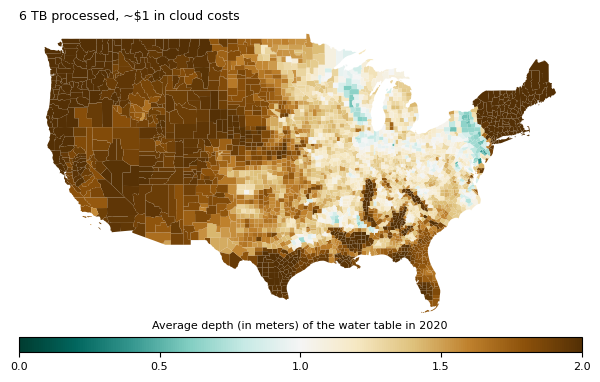

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(7.68, 4.32))

ax.set_axis_off()

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size='5%', pad=0.1)

cax.tick_params(labelsize=8)
cax.set_title("Average depth (in meters) of the water table in 2020", fontsize=8)

continental.plot(
    column="zwattablrt",
    cmap="BrBG_r",
    vmin=0,
    vmax=2,
    legend=True,
    ax=ax,
    cax=cax,
    legend_kwds={
        "orientation": "horizontal",
        "ticks": [0,0.5,1,1.5,2],
        }
)

plt.text(0, 1, "6 TB processed, ~$1 in cloud costs", transform=ax.transAxes, size=9)
plt.show()